# pyxem


### A 4-D STEM Package in the Hyperspy Ecosystem

#### Carter Francis, Direct Electron 
#### *June 05, 2025*

In [1]:
#pip install --upgrade pyxem

In [ ]:
#pip install awkward

In [1]:
import pyxem as pxm
import hyperspy.api as hs
import os

### Download the Data (Try to do this ahead of time!)

In [2]:
# Set that the data for should be downloaded
pxm.data.zrnb_precipitate(allow_download=True, lazy=True)
pxm.data.organic_semiconductor(allow_download=True, lazy=True)
pxm.data.sped_ag(allow_download=True, lazy=True)

WARNING | Hyperspy | `signal_type='Signal2D'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:745)


<LazyElectronDiffraction2D, title: , dimensions: (208, 64|112, 112)>

# Outline

1. Introduction to 4D STEM
2. Introduction to pyxem
3. Example Workflows
    1. Loading and Visualizing Data (This Notebook)
    2. Creating Virtual Images (MgO Nanocrystals) (This Notebook)
    3. Strain Mapping and Finding Vectors (Inclusions in ZrNb) (30 min) 
    4. Azimuthal Integration And Orientation Mapping in Molecular Glasses (30 min)

# Introduction to 4D STEM

<img src="Images/4DSTEM.gif" alt="4D STEM GIF">

# Introduction to pyxem (pix-em)


Because pyxem extends hyperspy importing hyperspy will automatically load pyxem if it is installed.

This also means that we inherit all of the upstream hyperspy functionality such as:

1. Fast I-O (from [many different file formats](https://hyperspy.org/rosettasciio/supported_formats/index.html))
2. Machine learning with [Matrix Factorization](https://hyperspy.org/hyperspy-doc/current/user_guide/mva.html)
3. Fitting with [1-D and 2-D functions](https://hyperspy.org/hyperspy-doc/current/user_guide/model.html)
4. [Interactive Plotting](https://hyperspy.org/hyperspy-doc/current/user_guide/visualisation.html)
5. [Metadata Handling](https://hyperspy.org/hyperspy-doc/current/user_guide/metadata_structure.html)
6. And __Much Much__ More!

For more information about pyxem check out our [github](https://github.com/pyxem/pyxem) our [documentation](https://pyxem.readthedocs.io/en/latest/) or the set of [tutorial notebooks](https://github.com/pyxem/pyxem-demos) or our new set of [examples](https://pyxem.readthedocs.io/en/stable/examples/index.html)

## Loading and Visualizing Data

Data in `pyxem` can be loaded exactly the same as loading data in `hyperspy`.  Many different formats are supported but only the `.hspy` (hdf5) and `.zspy` (zarr) formats retain all of the metadata

```python
import hyperspy.api as hs
s = hs.load("path/to/file/to/load.hspy")
```

Visualization can easily be done by then calling the function

```python
s.plot()
```


In [3]:
# Starting up a distributed Cluster locally 
# You don't have to do this but it helps to visualize what is happening
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client
# Ignore INFO below just giving informataion about the scheduler set up

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56642,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:56654,Total threads: 2
Dashboard: http://127.0.0.1:56657/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:56645,


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56642,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:56654,Total threads: 2
Dashboard: http://127.0.0.1:56657/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:56645,


In [5]:
import pyxem as pxm
import hyperspy.api as hs
hs.set_log_level("ERROR")

In [6]:
# setting the plotting backend (note this works much better with the qt backend!)
dp = pxm.data.sped_ag(lazy=True)

In [7]:
%matplotlib qt
dp.plot()

## Creating Virtual Images
We can construct Virtual images very easily using [ROIS](http://hyperspy.org/hyperspy-doc/current/user_guide/interactive_operations_ROIs.html) from `hyperspy`.

In [8]:
import hyperspy
import pyxem
print(hyperspy.__version__)
print(pyxem.__version__)
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 80

2.3.0
0.21.0


In [11]:
# This will work with lazy signals if they are small and stored efficiently.
dp.compute() 

AttributeError: 'ElectronDiffraction2D' object has no attribute 'compute'

In [12]:
# plot the data

# Lets make an couple of interactive ROI's 


# Making a 1D Interactive Plot:

A lot of times something like `hs.plot.plot_roi_map` doesn't really work unless you have the entire dataset in RAM.  This is kind of a shame, and something that we will try to discuss a little tomorrow (maybe we can fix that!)  One thing you might find youself doing is to take the 1D profile of the data and then integrate over some region in the 1D plot. 



In [13]:
# reload the data (lazily)
dp = pxm.data.sped_ag(lazy=True)

In [14]:
# get the azimuthal_integral1d and compute it


In [9]:
# plot the roi_map in hyperspy.

We can also define a specific ROI to create virtual Images.  A lot of times I like to use the pac bed and then create virtual images in a more iterative fashion. 

In [15]:

# get the mean diffraction pattern
# plot the mean diffraction pattern
# create a ROI to be used as a virtual appature
# add roi to plot
# create a ROI to be used as a virtual appature
# add roi to plot

In [16]:
# get the integrated intensity to make the virtual images.

# plot using plot images

[<Axes: title={'center': 'Virtual Dark Field'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <Axes: title={'center': 'Virtual Aperture'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

### Finding Diffraction Vectors and Crystal Segmentation

For many operations in `pyxem` such as Crystal Segmentation, Strain Mapping and Clustering we start with finding the set of diffraction vectors within the dataset.  This starts with the function `s.get_diffraction_vectors()`

##### Removing Background

For more infromation look at the [background subtraction example](https://pyxem.readthedocs.io/en/stable/examples/processing/background_subtraction.html#sphx-glr-examples-processing-background-subtraction-py)

In [17]:
import pyxem as pxm
import hyperspy.api as hs
hs.set_log_level("ERROR")

## Brief Aside into Disk Finding

Pyxem uses a window normalized template matching which I've found performs much better than other method for disk finding. The key is you are normalizing by the variance in a sliding window. 

There are lots of different ways to play with this.  Increasing your window size, using a non square window (this sometimes helps when you have lots of peaks.  You could even think about fitting the 1d profile of background and using that to normalize with instead (probably the best way to do it but I've never gotten around to writing that up...)


In [18]:
from scipy.signal import fftconvolve
from skimage.morphology import disk
import numpy as np
from skimage.feature import match_template

In [19]:
def cross_correlation(image, template, mode="constant", constant_values=1):
    pad_width = tuple((width, width) for width in template.shape)
    if mode == 'constant':
        image = np.pad(
            image, pad_width=pad_width, mode=mode, constant_values=constant_values
        )
    else:
        image = np.pad(image, pad_width=pad_width, mode=mode)
    return fftconvolve(one_dp, template[::-1,::-1])

In [20]:
one_dp = dp.data[40,50].compute()

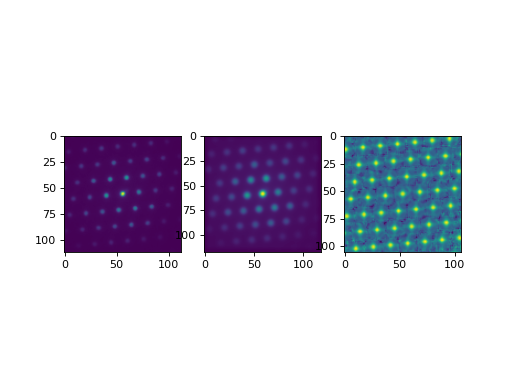

In [22]:
%matplotlib ipympl
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3)
axs[0].imshow(one_dp)
axs[1].imshow(cross_correlation(one_dp, disk(radius=3)))
axs[2].imshow(match_template(one_dp,  disk(radius=3)))

## And Back...

In [23]:
# Template match with a disk 


In [24]:
# compute navigator and pass along :) 


In [25]:
# plot


In [26]:
# find peaks using peak local max


In [27]:
%matplotlib ipympl
#plot the markers over the dataset


In [28]:
# compute the diffraction vectors


/Users/carterfrancis/hyperspy-bundle/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 17.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/Users/carterfrancis/hyperspy-bundle/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 17.99 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


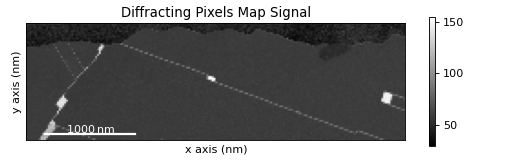

In [29]:
# plot the map (number found) of diffraction vectors 


In [30]:
import numpy as np
distance_threshold = 0.014
min_samples = 7
# cluster the vectors to get only the unique vectors
unique_peaks = dv.get_unique_vectors(method='DBSCAN',
                                          distance_threshold=distance_threshold,
                                          min_samples=min_samples, columns = (-3,-2))
print(np.shape(unique_peaks.data)[0], ' unique vectors were found.')

#remove the zero beam
unique_peaks = unique_peaks.filter_magnitude(min_magnitude=.4,
                                   max_magnitude=np.inf) 
print(np.shape(unique_peaks)[0], ' unique vectors.')

168  unique vectors were found.
145  unique vectors.


### Creating Virtual Images from Vectors

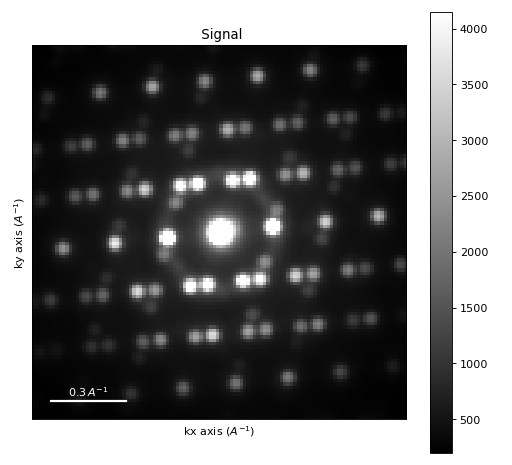

In [31]:
rois, texts = unique_peaks.to_roi(radius=.1,
                                  include_labels=True,
                                  sizes=2,
                                  facecolor="black", color="w")
mean_dp = dp.mean()
mean_dp.plot(vmax="99th")
vdfs = dp.get_virtual_image(rois)
mean_dp.add_marker(texts)

In [32]:
# display the vdfs object


<LazyVirtualDarkFieldImage, title: Stack of Integrated intensity, dimensions: (145|208, 64)>

In [33]:
# plot the vdfs (lazily)


In [34]:
# compute VDFS


### Another Aside:

Lets try to see if we can use our vectors to make a more responsive virtual image.  One of the (current) major problems in pyxem and hyperspy is that we are using Ragged Arrays in numpy!

These are __very__ slow.  Let's see if we can use some thing like awkward arrays to make things faster!!!!

(This is also a very, very good to do)

In [35]:
import awkward as ak
num = np.array([[int(len(v)) for v in vv ]for vv in dv.data])
ar = np.vstack([v for vv in dv.data for v in vv ])
a = ak.Array(ar)
awk_vectors = ak.unflatten(ak.unflatten(a, num.flatten()), num.shape[1])

In [36]:
def slice_ragged_vectors(vectors, roi):
    center = np.array([roi.cx, roi.cy, 0 ])[None, None,None] # Don't change the intensity
    shifted_vectors =  vectors - center
    distance = np.sqrt((shifted_vectors[:,:,:,0]**2+shifted_vectors[:,:,:,1]**2))
    is_in = ak.values_astype(distance<c.r, int)
    is_in = ak.values_astype(distance>c.r_inner, int) *is_in
    virtual_img = is_in  * vectors[:,:,:,2]
    virtual_img = np.sum(virtual_img, axis=-1)
    return hs.signals.Signal2D(virtual_img.to_numpy())

In [38]:
%matplotlib qt
mean_dp.plot(vmax="99th")
c= hs.roi.CircleROI(r=.4)
c.add_widget(mean_dp)
vdf_vectors = hs.interactive(slice_ragged_vectors, 
                             roi=c, 
                             vectors=awk_vectors,
                             event=c.events.changed, 
                             recompute_out_event=None,
                          )
vdf_vectors.plot()

### Ugh.....

All of that work and still slower than slicing an in memory array.  I guess computing distances is a bit of a drag...  I think we could be a little faster with a KD Tree? Maybe we will try that a little later. 

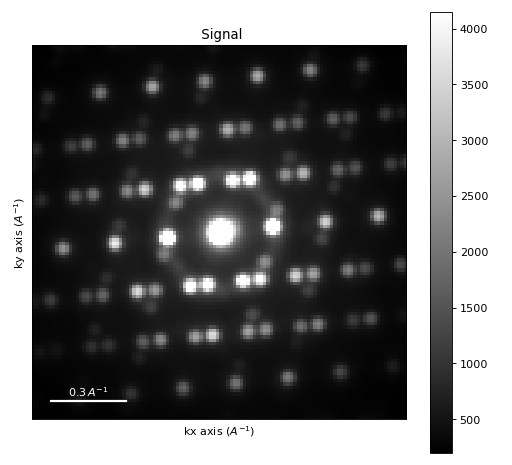

### Creating Segmented Detectors

In [41]:
import pyxem as pxm
from pyxem.utils._azimuthal_integrations import _get_control_points
import numpy as np
import hyperspy.api as hs

dp.calibration.center = None  # Center the diffraction patterns


# For Visualizing the virtual detector
cp = _get_control_points(
    1,
    npt_azim=8,
    radial_range=(.2, .6),
    azimuthal_range=(-np.pi, np.pi),
    affine=dp.calibration.affine,
)[:, :, ::-1]
poly = hs.plot.markers.Polygons(verts=cp, edgecolor="w", facecolor="none")
dp.plot()
dp.add_marker(poly)
pos = np.mean(cp, axis=1)
texts = np.arange(len(pos)).astype(str)
texts = hs.plot.markers.Texts(offsets=pos, texts=texts, color="w")
dp.add_marker(texts)

In [42]:
# Create a 2D Azimuthal Integral and plot the transpose


In [43]:
# Createa 1D Azimuthal Integral and plot the transpose
